In [1]:
from models import ResNet32Large,ResNet128
import numpy as np
import os.path as osp
from tensorflow.python.platform import flags
import tensorflow as tf
import imageio
import scipy.io as io
import cv2
import matplotlib.pyplot as plt
from utils import optimistic_restore
from skimage.measure import compare_psnr,compare_ssim
import glob
from US_pattern import US_pattern
import h5py as h5
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import sys
sys.argv = ["pKIEBM_Test_Demo.py","--swish_act"]

In [2]:
flags.DEFINE_string('logdir_I', 'cachedir', 'location where log of experiments will be stored')
flags.DEFINE_string('logdir_K', 'cachedir','location where log of experiments will be stored')
flags.DEFINE_integer('num_steps', 800, 'num of steps for conditional imagenet sampling')
flags.DEFINE_float('step_lr_I', 10, 'step size for Langevin dynamics')
flags.DEFINE_float('step_lr_K', 10, 'step size for Langevin dynamics')
flags.DEFINE_integer('batch_size', 1, 'number of steps to run')
flags.DEFINE_string('exp_I', 'SIAT_I', 'name of experiments')
flags.DEFINE_string('exp_K', 'SIAT_K', 'name of experiments')
flags.DEFINE_integer('resume_iter_I', 169500, 'iteration to resume training from')
flags.DEFINE_integer('resume_iter_K', 124500, 'iteration to resume training from')
flags.DEFINE_bool('spec_norm', True, 'whether to use spectral normalization in weights in a model')
flags.DEFINE_bool('cclass', True, 'conditional models')
flags.DEFINE_bool('use_attention', False, 'using attention')
FLAGS = flags.FLAGS
tf.app.flags.DEFINE_string('f', '', 'kernel')

In [3]:
def show(image):
    plt.imshow(image,cmap='gray')
    plt.xticks([])
    plt.yticks([])
def write_images(x,image_save_path):
    x = np.clip(x * 255, 0, 255).astype(np.uint8)
    cv2.imwrite(image_save_path, x)
def rescale_im(im):
    return np.clip(im * 256, 0, 255)#.astype(np.uint8)
    
def compare_hfen(rec,ori):
    operation = np.array(io.loadmat("./input_data/loglvbo.mat")['h1'],dtype=np.float32)
    ori = cv2.filter2D(ori.astype('float32'), -1, operation,borderType=cv2.BORDER_CONSTANT)
    rec = cv2.filter2D(rec.astype('float32'), -1, operation,borderType=cv2.BORDER_CONSTANT)
    hfen = np.linalg.norm(ori-rec, ord = 'fro')
    return hfen
    
def write_Data(psnr,ssim,hfen):
    with open(osp.join('./result/compare_modl/PKI/',"psnr_compare_modl.txt"),"w+") as f:
        f.writelines('['+str(round(psnr, 3))+' '+str(round(ssim, 4))+' '+str(round(hfen, 3))+']')
        f.write('\n')

def write_Data2(step,psnr,ssim,hfen):
    with open(osp.join('./result/compare_modl/PKI/',"psnr_T.txt"),"w+") as f:
        f.writelines('step='+str(step)+' ['+str(round(psnr, 3))+' '+str(round(ssim, 4))+' '+str(round(hfen, 3))+']')
        f.write('\n')

In [4]:

def FT(x,csm):
    """ This is a the A operator as defined in the paper"""
    ncoil,nrow,ncol = csm.shape
    ccImg=np.reshape(x,(nrow,ncol) )
    coilImages=np.tile(ccImg,[ncoil,1,1])*csm;
    kspace=np.fft.fft2(coilImages)/np.sqrt(nrow * ncol)

    #io.savemat(osp.join('./result/compare_ddp/'+'modl_csm'),{'csm':csm})    
    #io.savemat(osp.join('./result/compare_ddp/'+'modl_coilImages'),{'coilImages':coilImages})    
    #assert 0
    return kspace

def tFT(kspaceUnder,csm):
    """ This is a the A^T operator as defined in the paper"""
    ncoil,nrow,ncol = csm.shape
    #temp=np.zeros((ncoil,nrow,ncol),dtype=np.complex64)
    img=np.fft.ifft2(kspaceUnder)*np.sqrt(nrow*ncol)
    coilComb=np.sum(img*np.conj(csm),axis=0).astype(np.complex64)
    #coilComb=coilComb.ravel();
    return coilComb

In [5]:
def k2wgt(X,W):
    Y = np.multiply(X,W) 
    return Y

def wgt2k(X,W,DC):
    DC = np.squeeze(DC)
    Y = np.multiply(X,1./W)
    Y[W==0] = DC[W==0]    
    return Y

In [6]:
filename='./MoDL_share_data/demoImage.hdf5' #set the correct path here

In [7]:
with h5.File(filename,'r') as f:
    org,csm,mask=f['tstOrg'][:],f['tstCsm'][:],f['tstMask'][:]

#print(org.shape,csm.shape,mask.shape)
#(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
orim = org[0]
csm = csm[0]
patt = mask[0]

In [8]:

if __name__ == "__main__":

    model = ResNet128(num_filters=64)
    X_NOISE = tf.placeholder(shape=(None, 256, 232, 2), dtype=tf.float32)
    LABEL = tf.placeholder(shape=(None, 1), dtype=tf.float32)
    STD = tf.placeholder(shape=(None,1), dtype=tf.float32)
    CLIP_MAX = tf.placeholder(shape=(None, 1), dtype=tf.float32)
    CLIP_MIN = tf.placeholder(shape=(None, 1), dtype=tf.float32)
    LR = tf.placeholder(shape=(None, 1), dtype=tf.float32)
    
    sess_I = tf.InteractiveSession()
    sess_K = tf.InteractiveSession()

    # Langevin dynamics algorithm
    weights = model.construct_weights("context_0")  
    x_mod = X_NOISE
    x_mod1 = x_mod + tf.random_normal(tf.shape(x_mod),mean=0.0,stddev=STD[0,0])
    x_mod2 = x_mod + tf.random_normal(tf.shape(x_mod),mean=0.0,stddev=STD[0,0])
    x_mod3 = x_mod + tf.random_normal(tf.shape(x_mod),mean=0.0,stddev=STD[0,0])
    x_mod4 = x_mod + tf.random_normal(tf.shape(x_mod),mean=0.0,stddev=STD[0,0])
    x_mod5 = x_mod + tf.random_normal(tf.shape(x_mod),mean=0.0,stddev=STD[0,0])
    x_mod6 = x_mod + tf.random_normal(tf.shape(x_mod),mean=0.0,stddev=STD[0,0])
    x_mod7 = x_mod + tf.random_normal(tf.shape(x_mod),mean=0.0,stddev=STD[0,0])
    x_mod8 = x_mod + tf.random_normal(tf.shape(x_mod),mean=0.0,stddev=STD[0,0])  
    
    energy_noise1 = energy_start = model.forward(x_mod1, weights, label=LABEL, reuse=True, stop_at_grad=False, stop_batch=True)
    x_grad1 = tf.gradients(energy_noise1, [x_mod1])[0]
    energy_noise2 = energy_start = model.forward(x_mod2, weights, label=LABEL, reuse=True, stop_at_grad=False, stop_batch=True)
    x_grad2 = tf.gradients(energy_noise2, [x_mod2])[0]
    energy_noise3 = energy_start = model.forward(x_mod3, weights, label=LABEL, reuse=True, stop_at_grad=False, stop_batch=True)
    x_grad3 = tf.gradients(energy_noise3, [x_mod3])[0]
    energy_noise4 = energy_start = model.forward(x_mod4, weights, label=LABEL, reuse=True, stop_at_grad=False, stop_batch=True)
    x_grad4 = tf.gradients(energy_noise4, [x_mod4])[0]
    energy_noise5 = energy_start = model.forward(x_mod5, weights, label=LABEL, reuse=True, stop_at_grad=False, stop_batch=True)
    x_grad5 = tf.gradients(energy_noise5, [x_mod5])[0]
    energy_noise6 = energy_start = model.forward(x_mod6, weights, label=LABEL, reuse=True, stop_at_grad=False, stop_batch=True)
    x_grad6 = tf.gradients(energy_noise6, [x_mod6])[0]
    energy_noise7 = energy_start = model.forward(x_mod7, weights, label=LABEL, reuse=True, stop_at_grad=False, stop_batch=True)
    x_grad7 = tf.gradients(energy_noise7, [x_mod7])[0]
    energy_noise8 = energy_start = model.forward(x_mod8, weights, label=LABEL, reuse=True, stop_at_grad=False, stop_batch=True)
    x_grad8 = tf.gradients(energy_noise8, [x_mod8])[0]
    
    energy_noise_old = energy_noise1
    energy_noise = energy_noise1
    
    lr = LR[0,0]
    x_last = x_mod - (lr) * (x_grad1 + x_grad2 + x_grad3 + x_grad4 + x_grad5 + x_grad6 + x_grad7 + x_grad8)/8
    
    x_mod = x_last
    x_out = tf.clip_by_value(x_mod, CLIP_MIN[0,0], CLIP_MAX[0,0])

    # channel mean
    x_real=x_out[:,:,:,0]
    x_imag=x_out[:,:,:,1]
    x_complex = tf.complex(x_real,x_imag)
    x_output  = x_complex

    sess_I.run(tf.global_variables_initializer())
    sess_K.run(tf.global_variables_initializer())
    
    saver_I = loader_I = tf.train.Saver()
    saver_K = loader_K = tf.train.Saver()
    
    logdir_I = osp.join(FLAGS.logdir_I, FLAGS.exp_I)
    logdir_K = osp.join(FLAGS.logdir_K, FLAGS.exp_K)
    
    model_file_I = osp.join(logdir_I, 'model_{}'.format(FLAGS.resume_iter_I))
    model_file_K = osp.join(logdir_K, 'model_{}'.format(FLAGS.resume_iter_K))
    
    saver_I.restore(sess_I, model_file_I)
    saver_K.restore(sess_K, model_file_K)

#============================================================================================

    write_psnr=0
    write_ssim=0
    write_hfen=9999
    np.random.seed(1)
    lx = np.random.randint(0, 1, (FLAGS.batch_size))

    ims = []
    PSNR=[]
    im_complex=np.zeros((FLAGS.batch_size,256,232),dtype=np.complex128)

    #==========================================================================
    ori_complex = orim
    ori_complex = ori_complex/np.max(np.abs(ori_complex))
    #write_images(abs(ori_complex),osp.join('./result/compare_modl/PKI/'+'ori'+'.png'))
    #io.savemat(osp.join('./result/compare_modl/PKI/'+'MODL_ori'),{'img':ori_complex})
    
    ww = io.loadmat('./MoDL_share_data/MODL_weight10.mat')['weight']   

    kdata = np.fft.fft2(ori_complex)
    ksample = np.multiply(kdata,mask)
    k_w = k2wgt(np.fft.fftshift(ksample),ww)
    
    mask = patt #0.1666217672413793# R=6
    #io.savemat(osp.join('./MoDL_share_data/'+'random_mask_R6'),{'mask':mask})

    print('under_sampled rate:',np.sum(mask)/(256*232))
    ksp = FT(ori_complex,csm)  

    if len(mask.shape)==2:
        mask=np.tile(mask,(csm.shape[0],1,1))  
 
    #get multi coil undersample kspace by mask
    usksp = np.multiply(ksp,mask)
    undersample_kspace = usksp
    
    zero_fiiled = tFT(usksp,csm)
    #write_images(abs(zero_fiiled),osp.join('./result/compare_modl/PKI/'+'zero_fiiled'+'.png'))
    io.savemat(osp.join('./result/compare_modl/PKI/'+'zero_fiiled'),{'img':zero_fiiled})

    # use for getting degrade img and psnr,ssim,hfen in iteration
    psnr_zerofill = compare_psnr(255*abs(zero_fiiled),255*abs(ori_complex),data_range=255)
    ssim_zerofilled = compare_ssim(abs(zero_fiiled),abs(ori_complex),data_range=1)
    print('psnr_zerofilled: ',psnr_zerofill,'ssim_zerofilled: ',ssim_zerofilled) #25.95079970708028    
    
    x_mod_I = np.random.uniform(-1, 1, size=(FLAGS.batch_size, 256, 232, 2))
    x_mod_I[:,:,:,0] = np.real(zero_fiiled)
    x_mod_I[:,:,:,1] = np.imag(zero_fiiled)

    x_mod_K = np.random.uniform(-10, 10, size=(FLAGS.batch_size, 256, 232, 2))
    x_mod_K[:,:,:,0] = np.real(k_w)
    x_mod_K[:,:,:,1] = np.imag(k_w)

    labels = np.eye(1)[lx]

    std_I = np.eye(1)[lx]
    std_I[0,0] = 0.005
    clip_MAX_I = np.eye(1)[lx]
    clip_MAX_I[0,0] = 1
    clip_MIN_I = np.eye(1)[lx]
    clip_MIN_I[0,0] = -1
    LR_I = np.eye(1)[lx]
    LR_I[0,0] = FLAGS.step_lr_I

    std_K = np.eye(1)[lx]
    std_K[0,0] = 0.08
    clip_MAX_K = np.eye(1)[lx]
    clip_MAX_K[0,0] = 10
    clip_MIN_K = np.eye(1)[lx]
    clip_MIN_K[0,0] = -10
    LR_K = np.eye(1)[lx]
    LR_K[0,0] = FLAGS.step_lr_K 
    
    for i in range(FLAGS.num_steps):
        _, K_out= sess_K.run([energy_noise,x_output],{X_NOISE:x_mod_K, LABEL:labels,STD:std_K,CLIP_MAX:clip_MAX_K,CLIP_MIN:clip_MIN_K,LR:LR_K})
        _, I_out= sess_I.run([energy_noise,x_output],{X_NOISE:x_mod_I, LABEL:labels,STD:std_I,CLIP_MAX:clip_MAX_I,CLIP_MIN:clip_MIN_I,LR:LR_I})  
        
        #K
        K_temp = np.squeeze(K_out)
        K_temp2 = wgt2k(K_temp,ww,np.fft.fftshift(ksample))
        
        I_temp = np.fft.ifft2(np.fft.fftshift(K_temp2))
        K_complex = FT(I_temp,csm)
        
        #I
        I_complex = np.squeeze(I_out)
                
        #
        K_mean = (K_complex+FT(I_complex,csm))/2
        #K_mean = FT(I_complex,csm)
        #K_mean = K_complex
        
        # Data Consistance 
        iterkspace = undersample_kspace + K_mean*(1-mask)
        im_complex  = tFT(iterkspace,csm)
        
        # Back
        k_back = np.fft.fftshift(np.fft.fft2(im_complex))
        k_w = k2wgt(k_back,ww)    
        x_mod_K[:,:,:,0],x_mod_K[:,:,:,1]=np.real(k_w),np.imag(k_w)
        
        im_complex = np.expand_dims(im_complex, 0)
        x_mod_I[:,:,:,0],x_mod_I[:,:,:,1]=np.real(im_complex),np.imag(im_complex)        
        
        im_complex = im_complex[0]
        #im_complex=im_complex/np.max(abs(im_complex))
        #print(np.max(abs(im_complex)),np.min(abs(im_complex)))

        ################################################################################# SSIM
   
        ssim=compare_ssim(abs(im_complex),abs(ori_complex),data_range=1)
        
        if write_ssim<ssim:
            write_ssim=ssim
        ################################################################################# HFEN
        
        hfen=compare_hfen(abs(im_complex),abs(ori_complex))
        
        if write_hfen>hfen:
            write_hfen=hfen
        ################################################################################# PSNR
        
        psnr=compare_psnr(255*abs(im_complex),255*abs(ori_complex),data_range=255)
        err = abs(abs(im_complex) -abs(ori_complex))

        if write_psnr<psnr:
            write_psnr=psnr
            #write_Data2(i,psnr,ssim,hfen)
            #write_images(abs(im_complex),osp.join('./result/compare_modl/PKI/'+'PKI_EBMrec_'+'.png'))
            #write_images(abs(err)*5,osp.join('./result/compare_modl/PKI/'+'erro_CompareMmodl'+'.png'))
            io.savemat(osp.join('./result/compare_modl/PKI/'+'PKI_EBM_rec'),{'img':im_complex})

            
                                 
        print("step:{}".format(i),' PSNR:', psnr,' SSIM:', ssim,' HFEN:', hfen)
    

/home/lqg/.local/lib/python3.5/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


INFO:tensorflow:Restoring parameters from cachedir/SIAT_I/model_169500
INFO:tensorflow:Restoring parameters from cachedir/SIAT_K/model_124500
under_sampled rate: 0.1666217672413793
psnr_zerofilled:  25.95079970708028 ssim_zerofilled:  0.7779335463805443


pKIEBM_Test_Demo.py:7: RuntimeWarning: divide by zero encountered in true_divide


step:0  PSNR: 27.5820154552415  SSIM: 0.8170233333580703  HFEN: 2.1726568
step:1  PSNR: 28.7335201285546  SSIM: 0.8486768623618636  HFEN: 1.8625389
step:2  PSNR: 29.536747833642725  SSIM: 0.867597776707324  HFEN: 1.6585735
step:3  PSNR: 30.143361663280416  SSIM: 0.8803592614868194  HFEN: 1.5127299
step:4  PSNR: 30.62670204462741  SSIM: 0.8896766715262229  HFEN: 1.4021723
step:5  PSNR: 31.02633220467841  SSIM: 0.8968306984273678  HFEN: 1.3148084
step:6  PSNR: 31.365733363211675  SSIM: 0.9025269889893426  HFEN: 1.2435821
step:7  PSNR: 31.65997924421402  SSIM: 0.9071922242237058  HFEN: 1.1840826
step:8  PSNR: 31.91909376554992  SSIM: 0.9111027019112401  HFEN: 1.1334043
step:9  PSNR: 32.15015363126219  SSIM: 0.9144427275563051  HFEN: 1.0895609
step:10  PSNR: 32.35837928620305  SSIM: 0.917342012134423  HFEN: 1.051138
step:11  PSNR: 32.54773589804559  SSIM: 0.9198938271150451  HFEN: 1.017095
step:12  PSNR: 32.721226587298496  SSIM: 0.9221659127039828  HFEN: 0.98666024
step:13  PSNR: 32.88119

step:108  PSNR: 37.330566570359245  SSIM: 0.967545095278515  HFEN: 0.43575066
step:109  PSNR: 37.353272587506005  SSIM: 0.9677036548226267  HFEN: 0.4340944
step:110  PSNR: 37.37583815569599  SSIM: 0.9678605359555817  HFEN: 0.4324568
step:111  PSNR: 37.39824721962931  SSIM: 0.9680154698734981  HFEN: 0.43083623
step:112  PSNR: 37.42053034447344  SSIM: 0.9681688368526912  HFEN: 0.42923513
step:113  PSNR: 37.44266368993713  SSIM: 0.9683207051952648  HFEN: 0.42765033
step:114  PSNR: 37.46465182679804  SSIM: 0.9684712220916432  HFEN: 0.4260814
step:115  PSNR: 37.486519307692824  SSIM: 0.9686201140370106  HFEN: 0.4245265
step:116  PSNR: 37.508203548454304  SSIM: 0.9687668476745646  HFEN: 0.42299038
step:117  PSNR: 37.52977211464674  SSIM: 0.9689122141244952  HFEN: 0.42146927
step:118  PSNR: 37.55121862832094  SSIM: 0.969056208275319  HFEN: 0.41996527
step:119  PSNR: 37.572525883275915  SSIM: 0.9691989760528193  HFEN: 0.4184755
step:120  PSNR: 37.59372034207463  SSIM: 0.9693403374195598  HFEN:

step:214  PSNR: 39.19449649029782  SSIM: 0.978455327984157  HFEN: 0.32047132
step:215  PSNR: 39.20850931375798  SSIM: 0.9785222675507583  HFEN: 0.31973845
step:216  PSNR: 39.22244878939889  SSIM: 0.9785885416481162  HFEN: 0.31900856
step:217  PSNR: 39.236321009128126  SSIM: 0.9786542019144793  HFEN: 0.31828445
step:218  PSNR: 39.25016208568122  SSIM: 0.9787194221298476  HFEN: 0.31756374
step:219  PSNR: 39.26399798406497  SSIM: 0.9787846002177669  HFEN: 0.31684908
step:220  PSNR: 39.27774024074488  SSIM: 0.9788490660068564  HFEN: 0.3161372
step:221  PSNR: 39.29144963077491  SSIM: 0.978913163430778  HFEN: 0.31542903
step:222  PSNR: 39.30513273938529  SSIM: 0.9789771214379749  HFEN: 0.3147237
step:223  PSNR: 39.31874423939165  SSIM: 0.9790403422935301  HFEN: 0.31402537
step:224  PSNR: 39.33232238689688  SSIM: 0.9791032968950297  HFEN: 0.31332585
step:225  PSNR: 39.345877575339635  SSIM: 0.9791659961161407  HFEN: 0.31263268
step:226  PSNR: 39.359363911375404  SSIM: 0.9792280679588068  HFEN

step:320  PSNR: 40.45364364798453  SSIM: 0.9836586280357454  HFEN: 0.26056138
step:321  PSNR: 40.463683311861615  SSIM: 0.9836940385554054  HFEN: 0.26012707
step:322  PSNR: 40.473728850516466  SSIM: 0.9837295803814532  HFEN: 0.25969598
step:323  PSNR: 40.4837033475731  SSIM: 0.983764415047205  HFEN: 0.2592645
step:324  PSNR: 40.49367984821694  SSIM: 0.9837995835964458  HFEN: 0.25883695
step:325  PSNR: 40.50357684599056  SSIM: 0.9838341816227986  HFEN: 0.25841093
step:326  PSNR: 40.513460330001855  SSIM: 0.9838682718877729  HFEN: 0.25798824
step:327  PSNR: 40.523336618052454  SSIM: 0.9839027358894884  HFEN: 0.25756595
step:328  PSNR: 40.533190278682014  SSIM: 0.9839371871071668  HFEN: 0.2571436
step:329  PSNR: 40.542966996658464  SSIM: 0.9839708884572156  HFEN: 0.25672606
step:330  PSNR: 40.552738630983505  SSIM: 0.9840045285983569  HFEN: 0.2563081
step:331  PSNR: 40.56249382439362  SSIM: 0.9840380964325985  HFEN: 0.25589293
step:332  PSNR: 40.57224282808568  SSIM: 0.9840715605659339  H

step:426  PSNR: 41.37062111477142  SSIM: 0.9865491733851102  HFEN: 0.22337067
step:427  PSNR: 41.37803995871255  SSIM: 0.9865698823436925  HFEN: 0.22308983
step:428  PSNR: 41.38542561832396  SSIM: 0.9865907650097101  HFEN: 0.22281106
step:429  PSNR: 41.39283920473781  SSIM: 0.9866114083327537  HFEN: 0.22253087
step:430  PSNR: 41.4001424924069  SSIM: 0.9866316124711833  HFEN: 0.22225474
step:431  PSNR: 41.407507047062715  SSIM: 0.9866520105951607  HFEN: 0.22197668
step:432  PSNR: 41.41480059264018  SSIM: 0.9866723085968515  HFEN: 0.22170316
step:433  PSNR: 41.42205438282484  SSIM: 0.9866924997195051  HFEN: 0.2214296
step:434  PSNR: 41.42929390441752  SSIM: 0.9867125324336133  HFEN: 0.2211555
step:435  PSNR: 41.43652870180806  SSIM: 0.9867324218598065  HFEN: 0.22088262
step:436  PSNR: 41.443743394493  SSIM: 0.9867522193514698  HFEN: 0.22060968
step:437  PSNR: 41.45090915949158  SSIM: 0.9867718212650962  HFEN: 0.2203387
step:438  PSNR: 41.45809023206348  SSIM: 0.9867915011895682  HFEN: 0.

step:532  PSNR: 42.04744542838082  SSIM: 0.9882763197673524  HFEN: 0.1987591
step:533  PSNR: 42.05289615943417  SSIM: 0.9882889851239186  HFEN: 0.19856928
step:534  PSNR: 42.058384612392956  SSIM: 0.9883018237905631  HFEN: 0.19838136
step:535  PSNR: 42.06380192994316  SSIM: 0.9883144713017012  HFEN: 0.1981935
step:536  PSNR: 42.0692323698075  SSIM: 0.9883271199094912  HFEN: 0.19800454
step:537  PSNR: 42.07463721251288  SSIM: 0.9883398694693236  HFEN: 0.19781679
step:538  PSNR: 42.08004448517573  SSIM: 0.9883524706747511  HFEN: 0.19762808
step:539  PSNR: 42.08543345745041  SSIM: 0.9883647917715291  HFEN: 0.19744197
step:540  PSNR: 42.09076369554083  SSIM: 0.9883769584656932  HFEN: 0.19725785
step:541  PSNR: 42.09607476220665  SSIM: 0.9883892531496816  HFEN: 0.19707327
step:542  PSNR: 42.101383865775226  SSIM: 0.9884013447397609  HFEN: 0.19688846
step:543  PSNR: 42.106700933778434  SSIM: 0.9884133584084475  HFEN: 0.19670515
step:544  PSNR: 42.11201491772271  SSIM: 0.9884254453991925  HFE

step:638  PSNR: 42.547996827001086  SSIM: 0.9893626096636543  HFEN: 0.18187097
step:639  PSNR: 42.552045114590584  SSIM: 0.9893707170095695  HFEN: 0.18173698
step:640  PSNR: 42.55608115484953  SSIM: 0.989378941488802  HFEN: 0.18160465
step:641  PSNR: 42.56014524991446  SSIM: 0.989387267727712  HFEN: 0.18147302
step:642  PSNR: 42.56409497154236  SSIM: 0.9893948770399487  HFEN: 0.18134364
step:643  PSNR: 42.56808255269367  SSIM: 0.989402796778713  HFEN: 0.18121284
step:644  PSNR: 42.572056347377185  SSIM: 0.9894106794445994  HFEN: 0.18108276
step:645  PSNR: 42.57603102692117  SSIM: 0.9894186557277898  HFEN: 0.1809539
step:646  PSNR: 42.5800641931677  SSIM: 0.9894269070319298  HFEN: 0.18082574
step:647  PSNR: 42.5840528115019  SSIM: 0.9894348569403231  HFEN: 0.18069652
step:648  PSNR: 42.58797577487038  SSIM: 0.9894428336528174  HFEN: 0.18056859
step:649  PSNR: 42.59190158975794  SSIM: 0.9894507432743246  HFEN: 0.1804404
step:650  PSNR: 42.595768190765554  SSIM: 0.9894582826003303  HFEN: 

step:744  PSNR: 42.91900368532367  SSIM: 0.9900732264596194  HFEN: 0.16995856
step:745  PSNR: 42.92197394315899  SSIM: 0.9900784969919307  HFEN: 0.16986454
step:746  PSNR: 42.924962019267284  SSIM: 0.9900838633348301  HFEN: 0.16977088
step:747  PSNR: 42.927864713156616  SSIM: 0.9900890426691419  HFEN: 0.16967908
step:748  PSNR: 42.93080809233436  SSIM: 0.9900941161696049  HFEN: 0.16958728
step:749  PSNR: 42.93376962316982  SSIM: 0.9900994805327427  HFEN: 0.1694948
step:750  PSNR: 42.93678144436545  SSIM: 0.9901050747102424  HFEN: 0.16940208
step:751  PSNR: 42.93973678028652  SSIM: 0.990110405761403  HFEN: 0.16930786
step:752  PSNR: 42.94272587382891  SSIM: 0.9901159339137044  HFEN: 0.16921547
step:753  PSNR: 42.94562750448908  SSIM: 0.9901211041935429  HFEN: 0.16912462
step:754  PSNR: 42.948539481455875  SSIM: 0.990126210057096  HFEN: 0.16903353
step:755  PSNR: 42.95151530697156  SSIM: 0.9901316790197299  HFEN: 0.16894227
step:756  PSNR: 42.95440668247589  SSIM: 0.990136784936837  HFEN

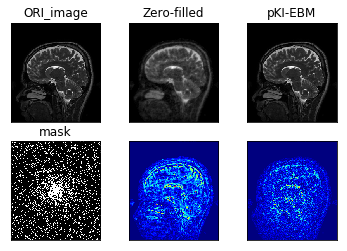

In [23]:
    # show rec image
    ori_image = io.loadmat('./result/compare_modl/PKI/MODL_ori.mat')['img']
    zero_fiiled = io.loadmat('./result/compare_modl/PKI/zero_fiiled.mat')['img']
    rec_image = io.loadmat('./result/compare_modl/PKI/PKI_EBM_rec.mat')['img']
    mask0 = io.loadmat('./MoDL_share_data/random_mask_R6.mat')['mask']
    mask = np.fft.fftshift(mask0) 
    ori_image = ori_image/np.max(abs(ori_image))
    zero_fiiled = zero_fiiled/np.max(abs(zero_fiiled))
    rec_image = rec_image/np.max(abs(rec_image))
    
    err1 = abs(abs(ori_image)-abs(zero_fiiled))
    err2 = abs(abs(ori_image)-abs(rec_image))

    plt.subplot(2,3,1)
    plt.imshow(abs(ori_image),cmap='gray')
    plt.title('ORI_image')
    plt.xticks([])
    plt.yticks([]) 
    
    plt.subplot(2,3,2)
    plt.imshow(abs(zero_fiiled),cmap='gray')
    plt.title('Zero-filled')
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(2,3,3)
    plt.imshow(abs(rec_image),cmap='gray')
    plt.title('pKI-EBM')
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(2,3,4)
    plt.imshow(abs(mask),cmap='gray')
    plt.title('mask')
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(2,3,5)
    plt.imshow(abs(err1),cmap='jet')
    plt.xticks([])
    plt.yticks([])    
 
    plt.subplot(2,3,6)
    plt.imshow(abs(err2),cmap='jet')
    plt.xticks([])
    plt.yticks([])
    
    
    
    plt.show()